In [1]:
import numpy as np
import xarray as xr
from dask.diagnostics import ProgressBar
from xgcm import Grid
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

%matplotlib inline

In [2]:
datapath = '/srv/scratch/z3097808/20year_run/20year_freerun_output_NEWnci/'
ts = xr.open_mfdataset(datapath + 'outer_avg_*.nc', chunks={'ocean_time': 10}, combine='by_coords', decode_coords=True)

In [3]:
ProgressBar().register()
print('Total Size: %6.2F GB' % (ts.nbytes / 1e9))

Total Size: 509.39 GB


In [4]:
#ts

In [5]:

i = 150         # southward boundary
ii = 160         # northward boundary
j = 90          # westward boundary
jj = 100         # eastward boundary
ds = ts.isel(eta_psi=slice(i,ii-1), eta_rho=slice(i,ii), eta_u=slice(i,ii), eta_v=slice(i,ii-1),
             xi_psi=slice(j,jj-1), xi_rho=slice(j,jj), xi_u=slice(j,jj-1), xi_v=slice(j,jj))

print('Total Size: %6.2F GB' % (ds.nbytes / 1e9))

Total Size:   0.58 GB


# Creating a grid object
While xgcm doesn't currently have an implementation for the SGRID convention for ROMS, a workaround consist on renaming eta_u and xi_v dimensions to rho. With this replacement 'psi' points have now a position (eta_v, xi_u). See issue here https://github.com/xgcm/xgcm/issues/108

Here I also test to see if the new XGCM 'metrics' functionality works.

In [6]:
# Including metrics
ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}}

grid = Grid(ds, coords=coords, periodic=[])

Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = Zo_rho * (ds.zeta + ds.h) + ds.zeta
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')


ds['pm_v'] = grid.interp(ds.pm, 'Y')
ds['pn_u'] = grid.interp(ds.pn, 'X')
ds['pm_u'] = grid.interp(ds.pm, 'X')
ds['pn_v'] = grid.interp(ds.pn, 'Y')
ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

ds['dx'] = 1/ds.pm
ds['dx_u'] = 1/ds.pm_u
ds['dx_v'] = 1/ds.pm_v
ds['dx_psi'] = 1/ds.pm_psi

ds['dy'] = 1/ds.pn
ds['dy_u'] = 1/ds.pn_u
ds['dy_v'] = 1/ds.pn_v
ds['dy_psi'] = 1/ds.pn_psi

ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
ds['dz_u'] = grid.interp(ds.dz, 'X')
ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
ds['dz_v'] = grid.interp(ds.dz, 'Y')
ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

ds['dA'] = ds.dx * ds.dy

metrics = {
    ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
    ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
    ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
    ('X', 'Y'): ['dA'] # Areas
}
grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

/home/z3526974/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  from ipykernel import kernelapp as app
/home/z3526974/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  app.launch_new_instance()


In [7]:
grid

<xgcm.Grid>
X Axis (not periodic):
  * center   xi_rho --> inner
  * inner    xi_u --> center
Y Axis (not periodic):
  * center   eta_rho --> inner
  * inner    eta_v --> center
Z Axis (not periodic):
  * center   s_rho --> outer
  * outer    s_w --> center

In [8]:
#calculate temperature advection at each gridpoint
ds['T_u'] = grid.interp(ds.u, axis='X', boundary = 'extend')*ds.temp
ds['T_v'] = grid.interp(ds.v, axis='Y', boundary = 'extend')*ds.temp

ds['T_uz'] = (grid.integrate(ds.T_u, 'Z'))/ds.h
ds['T_vz']= (grid.integrate(ds.T_v, 'Z'))/ds.h
ds.T_uz

<xarray.DataArray 'T_uz' (ocean_time: 8309, eta_rho: 10, xi_rho: 10)>
dask.array<truediv, shape=(8309, 10, 10), dtype=float64, chunksize=(10, 10, 8), chunktype=numpy.ndarray>
Coordinates:
    lat_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>
    lon_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>
  * ocean_time  (ocean_time) datetime64[ns] 1994-01-01T12:00:00 ... 2016-09-30T12:00:00
Dimensions without coordinates: eta_rho, xi_rho

[########################################] | 100% Completed |  7.2s


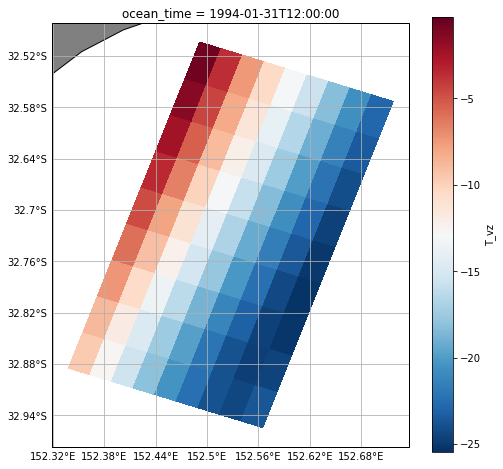

In [9]:
fig = plt.figure(figsize=(8,8))
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')
ax = plt.axes(projection=ccrs.PlateCarree())
feature = ax.add_feature(coast, edgecolor='black',facecolor='gray')
ds.T_vz.sel(ocean_time='1994-01-31T12').plot(ax=ax, transform=ccrs.PlateCarree(), 
                                        x='lon_rho', y='lat_rho', cmap='RdBu_r')
gl = ax.gridlines(draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = gl.ylabels_right = False

In [10]:
#Calculate heat transport
Cp = 4181.3
Rho_0 = 1025

In [11]:
s = (Cp*Rho_0*grid.integrate(ds.T_vz, 'X').sel(eta_rho=-1))
n = (Cp*Rho_0*grid.integrate(ds.T_vz, 'X').sel(eta_rho=0)*-1)
w = (Cp*Rho_0*grid.integrate(ds.T_uz, 'Y').sel(xi_rho=0)*-1)
e = (Cp*Rho_0*grid.integrate(ds.T_uz, 'Y').sel(xi_rho=-1))
tot_heat_adv = (n+s+e+w)/((ii-i)*(jj-j)*2500*5000)

In [ ]:
n.plot(label='north')
s.plot(label='south')
e.plot(label='east')
w.plot(label='west')
plt.legend()
plt.title('heat transport into box')
#plt.savefig('heat_transport.png', dpi=300,bbox_inches='tight')

[#########################               ] | 64% Completed | 13min 17.5s

In [ ]:
tot_heat_adv.plot(label='tot_heat_adv')
plt.legend()
plt.title('heat transport into box')
#plt.savefig('heat_transport.png', dpi=300,bbox_inches='tight')

In [ ]:
# Surface heat flux (per m2)
tot_Q = (grid.integrate(ds.shflux, ['X','Y']))/((ii-i)*(jj-j)*2500*5000)
tot_Q.plot()

In [ ]:
tendency = tot_heat_adv - tot_Q
tendency.plot()

In [ ]:
# Temperature tendency
Temp_z = (Rho_0*Cp*(grid.integrate(ds.temp,'Z')))/ds.h
Temp_tend = (grid.integrate(Temp_z,['X','Y']))/((ii-i)*(jj-j)*2500*5000)

In [ ]:
Temp_tend.plot()

In [ ]:
ProgressBar().unregister()